In [3]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from copy import deepcopy
bary_scenarios = ['mb2', 'illustris', 'eagle', 'HzAGN', 'TNG100', 'cowls_AGN', 'cowls_AGN_T8p5',
                      'cowls_AGN_T8p7', 'BAHAMAS', 'BAHAMAS_T7p6', 'BAHAMAS_T8p0']

def readCov(cov_fn):
    lines = np.genfromtxt(cov_fn)
    nd = np.max(lines[:,0]).astype(int)+1
    cov = np.zeros([nd, nd])
    for line in lines:
        i,j = int(line[0]), int(line[1])
        cg, cng = line[8], line[9]
        cov[i,j] = cg+cng
        cov[j,i] = cg+cng
    return cov

def generate_baryonic_PCA(cov_fn, data_vector_fmt, PCs_fn, write=False, remove=['illustris']):
    # we exclude "illustris"
    _bary_scenarios = deepcopy(bary_scenarios)
    for sce in remove:
        _bary_scenarios.remove(sce)
    
    cov = readCov(cov_fn)
    cov_L_cholesky = LA.cholesky(cov)
    inv_cov_L_cholesky = LA.inv(cov_L_cholesky)
    
    modelv_dm = np.genfromtxt(data_vector_fmt+"_dmo")[:,1]
    ndata_reduced = len(modelv_dm)
    nbaryons_scenario = len(_bary_scenarios)
    baryon_diff = np.zeros(shape=(ndata_reduced, nbaryons_scenario))

    for i in range(nbaryons_scenario):
        modelv_baryon = np.genfromtxt(data_vector_fmt+"_%s"%(_bary_scenarios[i]))[:,1]
        baryon_diff[:,i] = (modelv_baryon-modelv_dm)

    baryon_weighted_diff = np.dot(inv_cov_L_cholesky, baryon_diff)

    U, Sdig, VT = LA.svd(baryon_weighted_diff, full_matrices=True)
    
    # MAKE SURE WHATEVER VERSION OF NP HAVE U IN THE RIGHT ORDER
    if(np.all(np.diff(Sdig) <= 0) != True):
        raise LoggedError(self.log, "LOGICAL ERROR WITH NUMPY FUNCTION GEN PCA")

    PCs = np.empty(shape=(ndata_reduced, nbaryons_scenario))

    for i in range(nbaryons_scenario):
        PCs[:,i] = U[:,i]

    PCs = np.dot(cov_L_cholesky, PCs)

#     # Now we need to expand the number of dimensions
#     ndata = ci.get_ndim()
#     PCS_FINAL = np.empty(shape=(ndata, nbaryons_scenario))

#     for i in range(nbaryons_scenario):
#         PCS_FINAL[:,i] = ci.get_expand_dim_from_masked_reduced_dim(PCs[:,i])
    if write:
        np.savetxt(PCs_fn, PCs)
    return Sdig
        
def get_PC_amplitude(cov_fn, PCs_fn, data_vector_fmt, bary_scenario):
    ''' retrieve the Qs of a specific baryon scenario
    '''
    cov = readCov(cov_fn)
    cov_L_cholesky = LA.cholesky(cov)
    inv_cov_L_cholesky = LA.inv(cov_L_cholesky)
    
    modelv_dm = np.genfromtxt(data_vector_fmt+"_dmo")[:,1]
    ndata_reduced = len(modelv_dm)
    modelv_baryon = np.genfromtxt(data_vector_fmt+"_%s"%(bary_scenario))[:,1]
    baryon_diff = modelv_baryon - modelv_dm
    baryon_diff_weighted = np.dot(inv_cov_L_cholesky, baryon_diff)
    
    baryon_PCs = np.genfromtxt(PCs_fn)
    baryon_PCs_deweight = np.dot(inv_cov_L_cholesky, baryon_PCs)
    
    Qs = np.dot(baryon_PCs_deweight.T, baryon_diff_weighted)
    
    return Qs

In [4]:
dvfmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/DESI2_KL_%d%d_shear_shear_Ntomo4_Ncl15"
covfmt="/xdisk/timeifler/jiachuanxu/DESI2KL/cov/DESI2_KL_v2_%d%d_ssss_cov_Ncl15_Ntomo4"
PCs_fmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/DESI2_KL_%d%d_shear_shear_Ntomo4_Ncl15_9sim.pca"

In [5]:
for i in range(6): # target selection
    for j in range(6): # shape noise (different weights)
        # use 9 simulations to generate PCs
        var_frac = generate_baryonic_PCA(covfmt%(i,j), dvfmt%(i,0), PCs_fmt%(i,j), write=True, 
                                         remove=['illustris', 'eagle'])
        var_frac = var_frac / np.sum(var_frac) * 100
        # sanity test by the fraction of variance of the first three PCs
        print(f'Fraction of variance: %.2f / %.2f / %2f percents'%(var_frac[0], var_frac[1], var_frac[2]))

Fraction of variance: 78.64 / 14.47 / 4.101353 percents
Fraction of variance: 83.15 / 11.56 / 3.086658 percents
Fraction of variance: 85.16 / 10.18 / 2.697189 percents
Fraction of variance: 86.20 / 9.47 / 2.496011 percents
Fraction of variance: 86.57 / 9.26 / 2.405470 percents
Fraction of variance: 86.61 / 9.24 / 2.403398 percents
Fraction of variance: 80.79 / 13.01 / 3.764307 percents
Fraction of variance: 84.23 / 10.66 / 3.059422 percents
Fraction of variance: 85.06 / 10.07 / 2.897079 percents
Fraction of variance: 85.63 / 9.69 / 2.772185 percents
Fraction of variance: 85.83 / 9.55 / 2.736430 percents
Fraction of variance: 85.80 / 9.55 / 2.748959 percents
Fraction of variance: 77.78 / 14.78 / 4.638000 percents
Fraction of variance: 82.89 / 11.37 / 3.560450 percents
Fraction of variance: 84.07 / 10.59 / 3.297889 percents
Fraction of variance: 84.97 / 10.04 / 3.071299 percents
Fraction of variance: 85.32 / 9.80 / 2.994389 percents
Fraction of variance: 85.30 / 9.80 / 3.005288 percents


Get the Qs of each scenarios

In [6]:
Qs_range_9sim = []
for i in range(6): # target selection
    for j in range(6): # shape noise (different weights)
        Qs_dict = {}
        for sce in bary_scenarios:
            Qs = get_PC_amplitude(covfmt%(i,j), PCs_fmt%(i,j), dvfmt%(i,0), sce)
            Qs_dict[sce] = Qs
        Qs_range_9sim.append(Qs_dict)

In [8]:
Qs_range_10sim = []
PCs_10sim = "/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/DESI2_KL_%d%d_shear_shear_Ntomo4_Ncl15_10sim.pca"
for i in range(6): # target selection
    for j in range(6): # shape noise (different weights)
        Qs_dict = {}
        for sce in bary_scenarios:
            Qs = get_PC_amplitude(covfmt%(i,j), PCs_10sim%(i,j), dvfmt%(i,0), sce)
            Qs_dict[sce] = Qs
        Qs_range_10sim.append(Qs_dict)

Target selection 0; Shape noise 0
Q1 range (-44.33448480188775, 2.5136716607057705)
Q2 range (-8.451640607573124, 6.314540574899226)
Q3 range (-5.271612433386471, 2.8678027716697345)
Target selection 0; Shape noise 1
Q1 range (-24.918655580014896, 0.9566851605761261)
Q2 range (-3.47224735603176, 2.535680813493979)
Q3 range (-1.0657360108243639, 2.1755480692199805)
Target selection 0; Shape noise 2
Q1 range (-15.759293812438912, 0.4618532708079095)
Q2 range (-1.8408309515288894, 1.3319050834870008)
Q3 range (-0.5328346249659042, 1.1807389583157044)
Target selection 0; Shape noise 3
Q1 range (-7.426356855324167, 0.15322748451008442)
Q2 range (-0.7762377854426268, 0.5518297673334276)
Q3 range (-0.2075289893451093, 0.4956344208032726)
Target selection 0; Shape noise 4
Q1 range (-2.2980672267303124, 0.025777388165064648)
Q2 range (-0.22573147714505348, 0.15542842364921355)
Q3 range (-0.05483098964121477, 0.13532742537304504)
Target selection 0; Shape noise 5
Q1 range (-1.0741734299685608, 0

/tmp/ipykernel_56403/3107022496.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=[8,8])


Target selection 3; Shape noise 2
Q1 range (-1.1490513720481959, 0.03674645006754253)
Q2 range (-0.1270966784762414, 0.10247500586584657)
Q3 range (-0.048989981683732316, 0.09761757402611165)
Target selection 3; Shape noise 3
Q1 range (-0.4898477455018287, 0.011182734238895823)
Q2 range (-0.05039395553897842, 0.039825697821117)
Q3 range (-0.018466418100708714, 0.0386780592802897)
Target selection 3; Shape noise 4
Q1 range (-0.13096476876806462, 0.00248010820278665)
Q2 range (-0.01323983899534317, 0.0102635257662055)
Q3 range (-0.004710757744040293, 0.010227402592556277)
Target selection 3; Shape noise 5
Q1 range (-0.058713101698820866, 0.0010777986955875186)
Q2 range (-0.005940739890999889, 0.004581575019736651)
Q3 range (-0.002100875301788987, 0.004600537016374377)
Target selection 4; Shape noise 0
Q1 range (-5.295907666320859, 0.2956537289002007)
Q2 range (-0.8123972660750262, 0.7213715055552102)
Q3 range (-0.36654813182043366, 0.5807038630496432)
Target selection 4; Shape noise 1
Q1

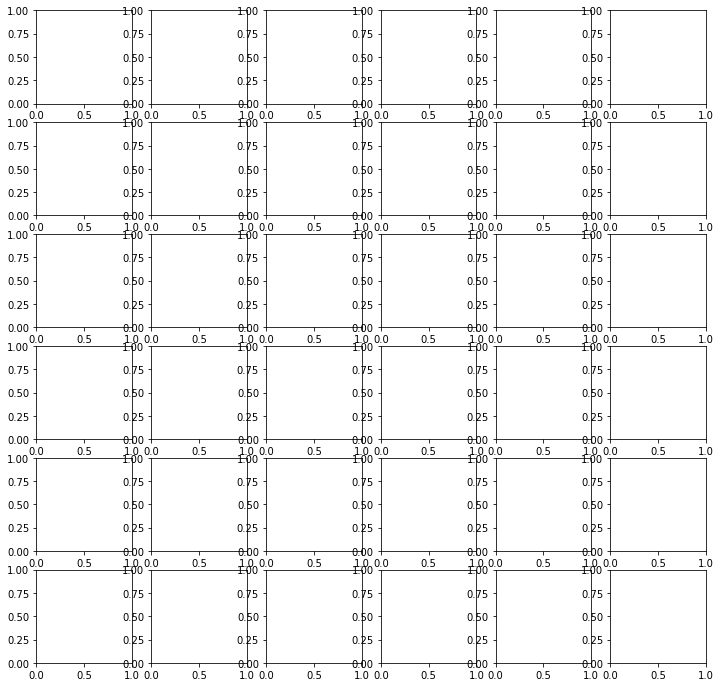

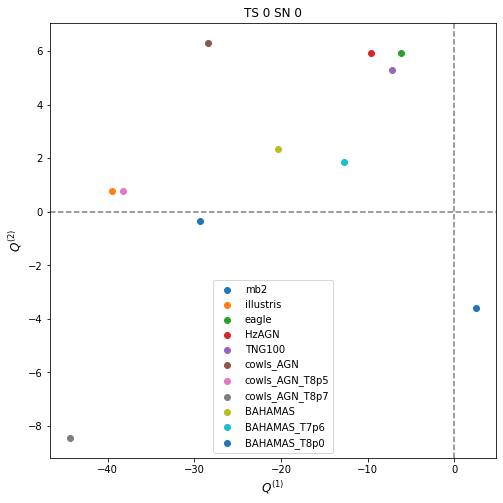

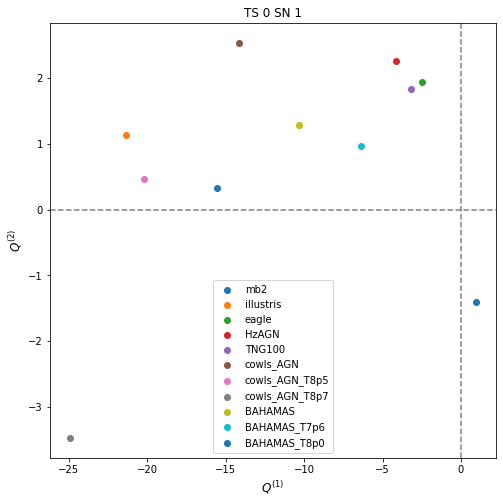

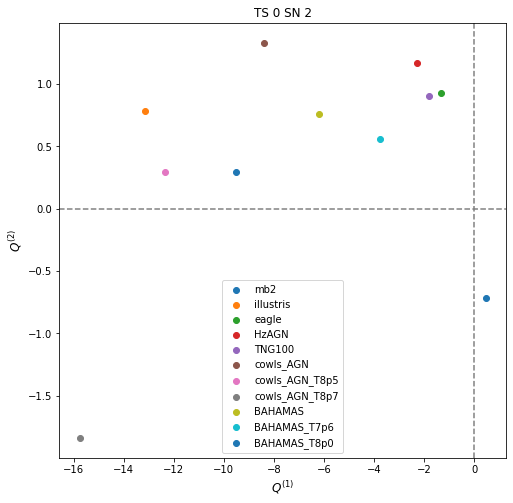

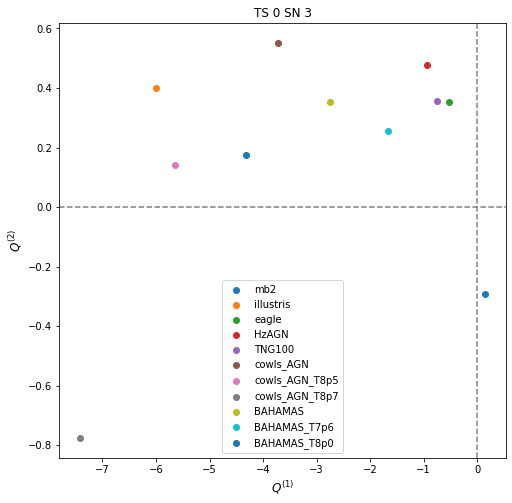

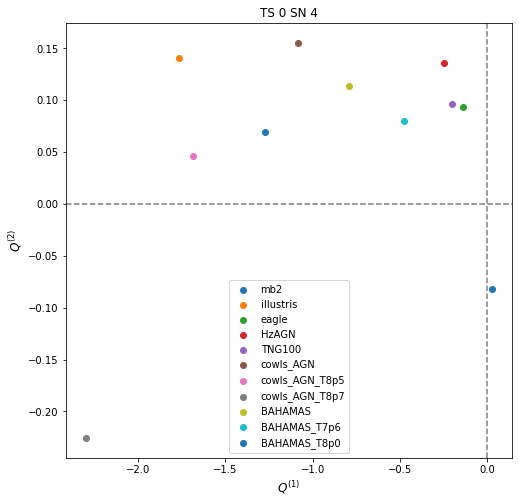

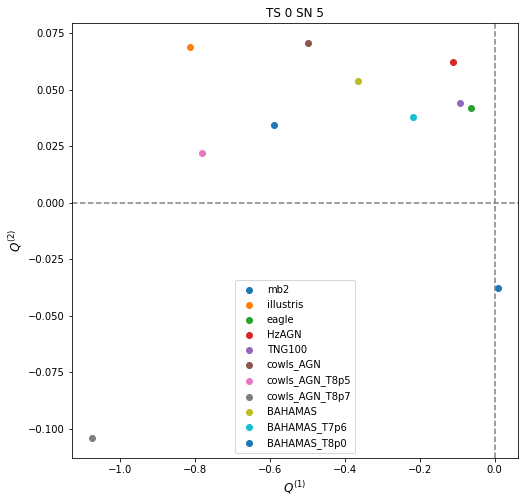

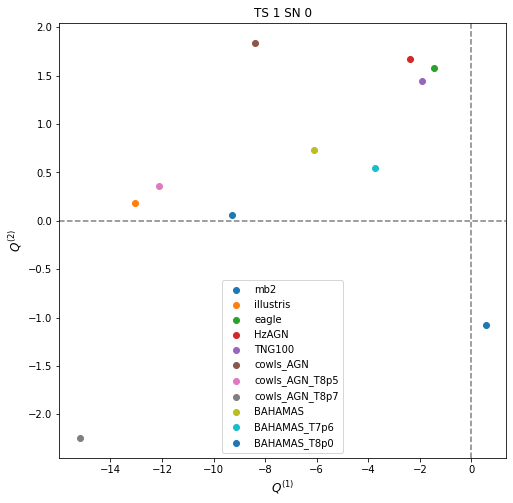

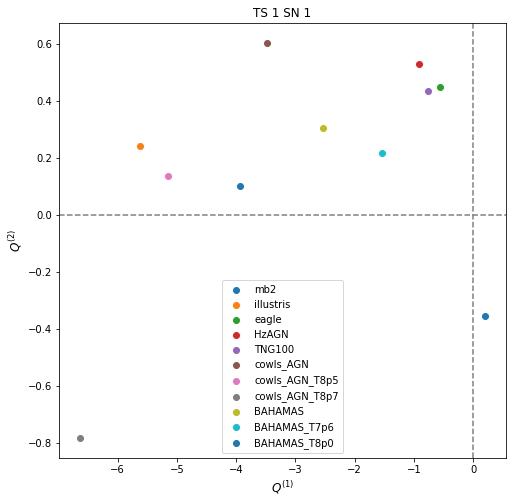

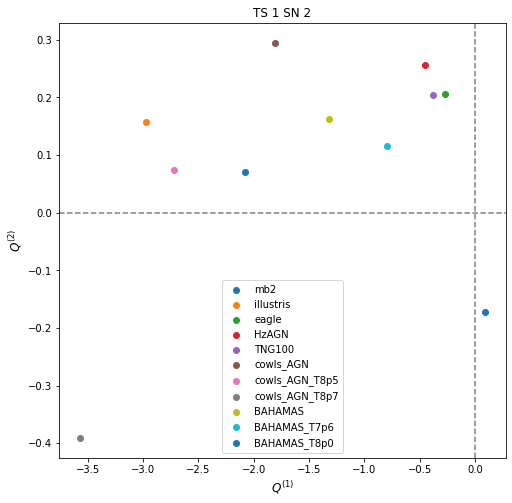

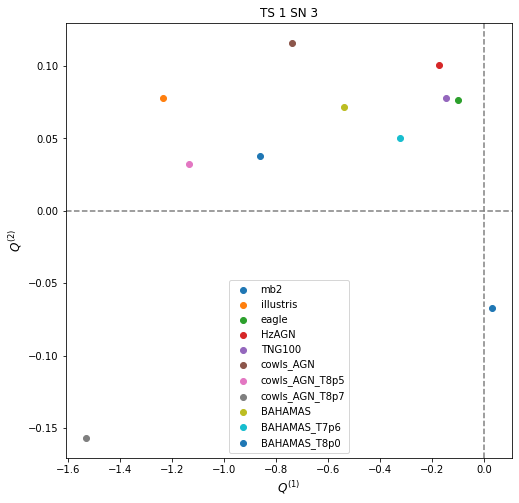

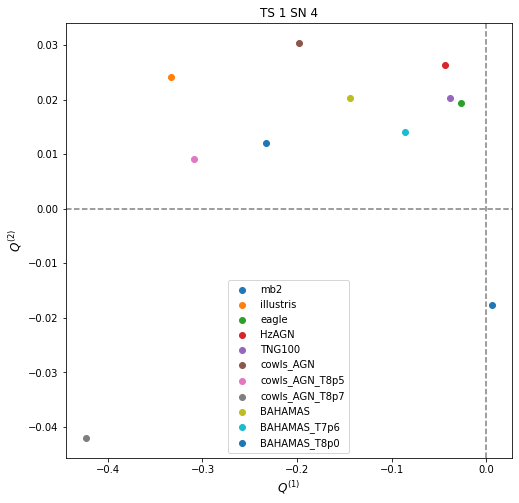

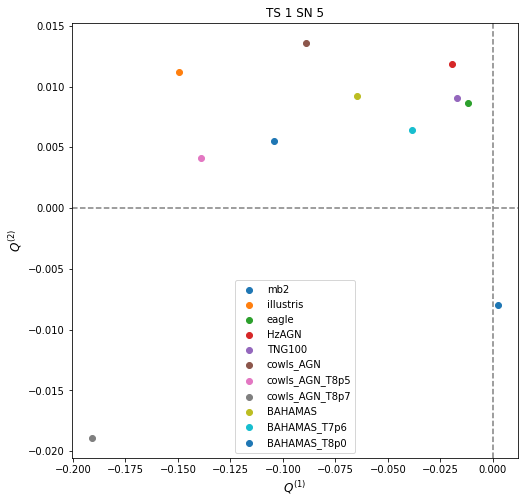

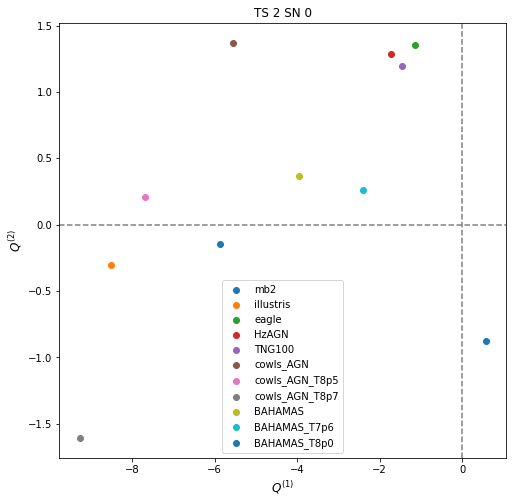

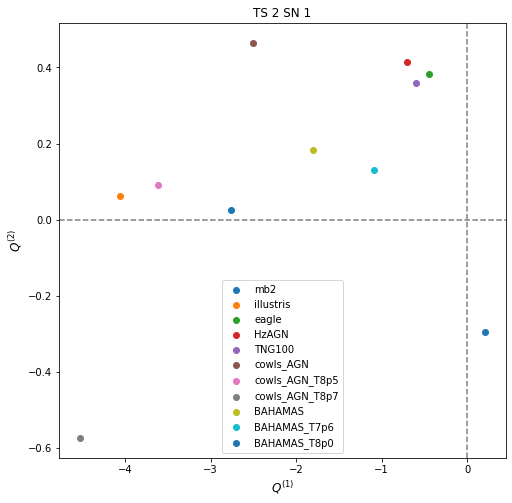

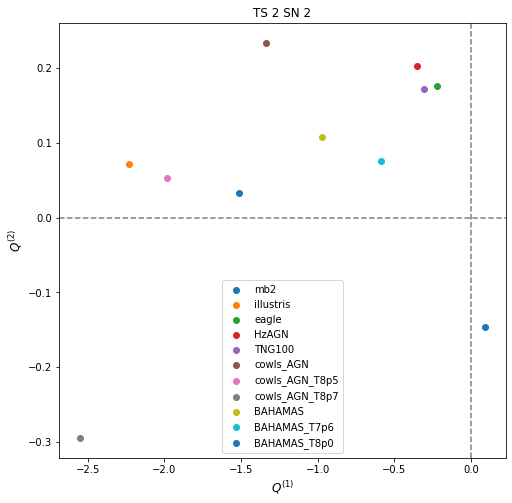

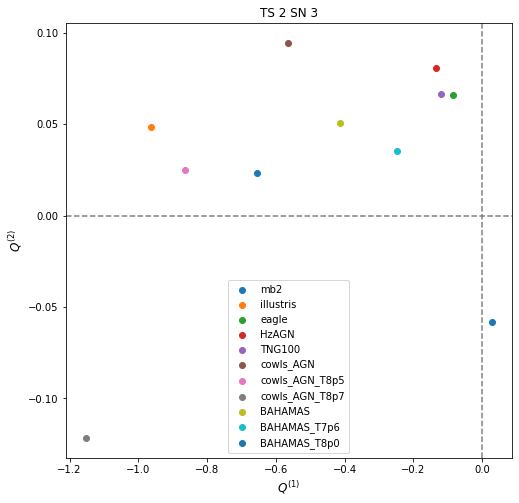

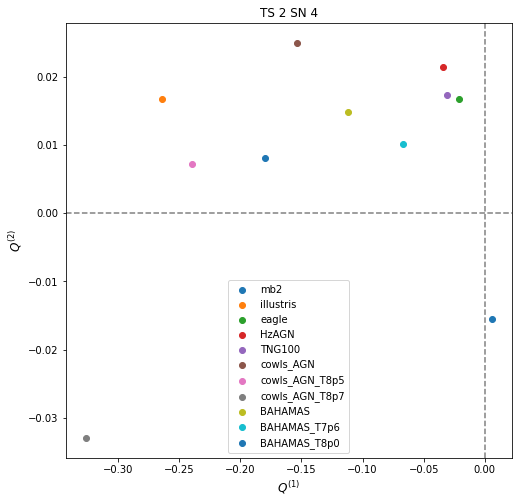

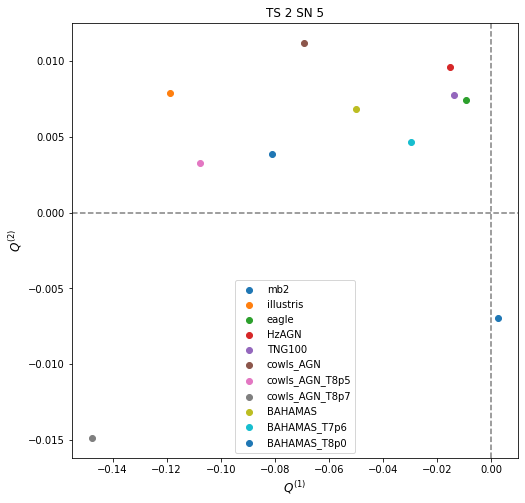

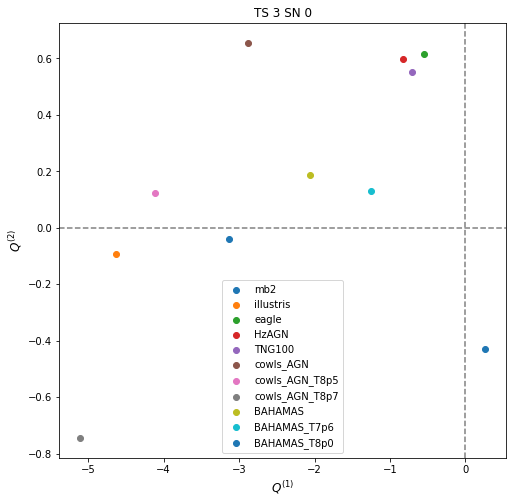

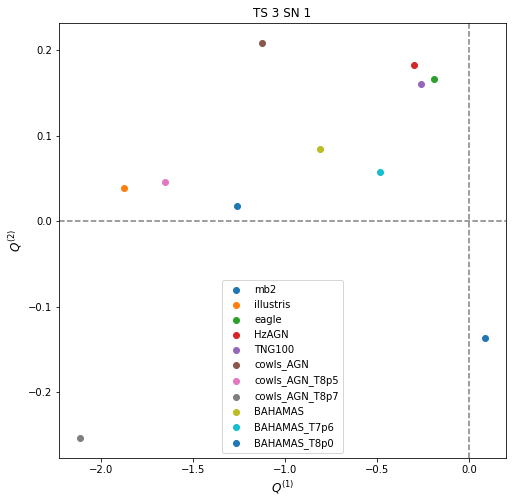

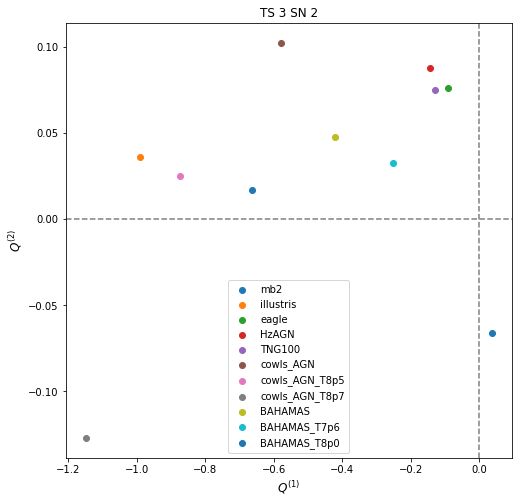

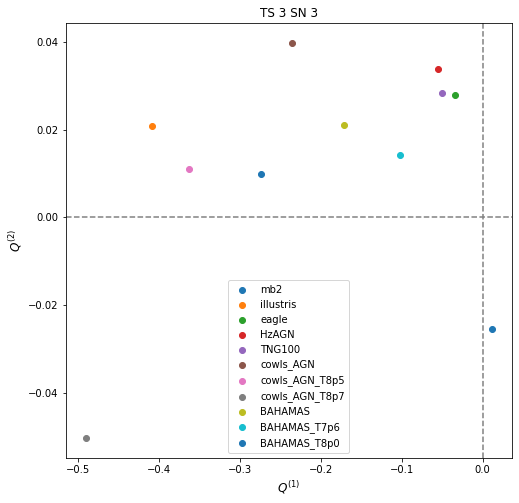

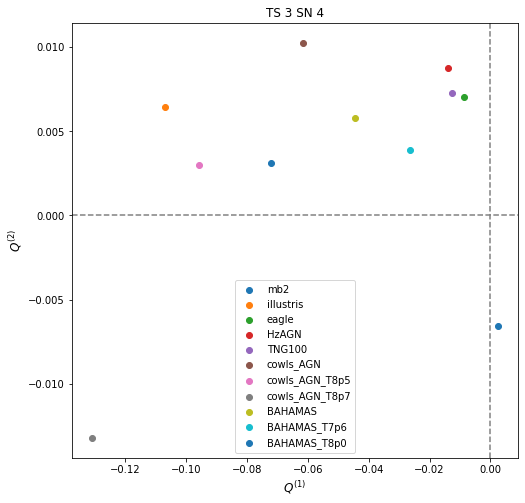

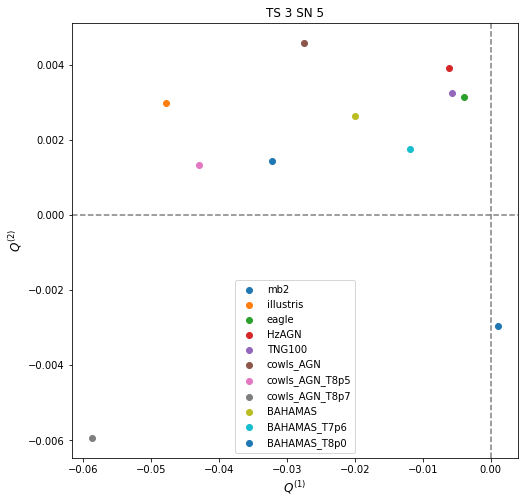

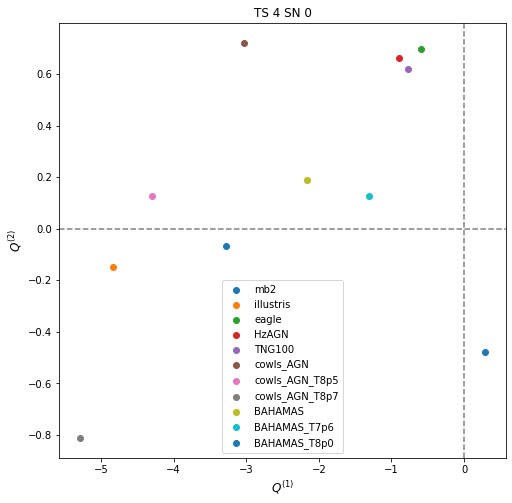

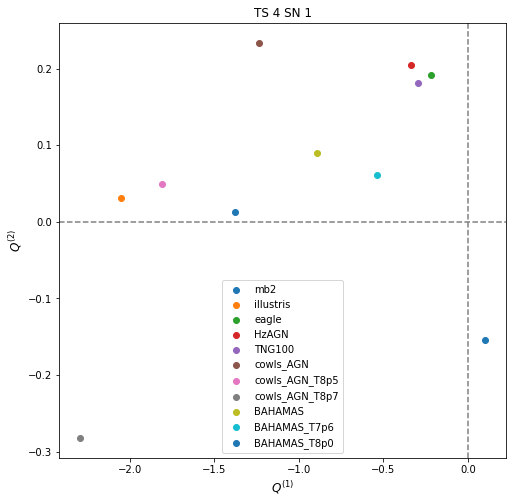

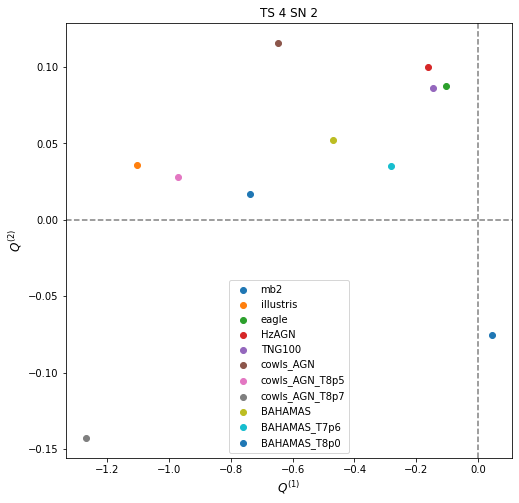

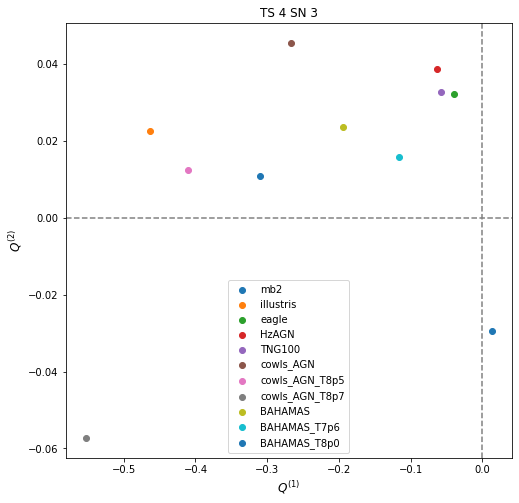

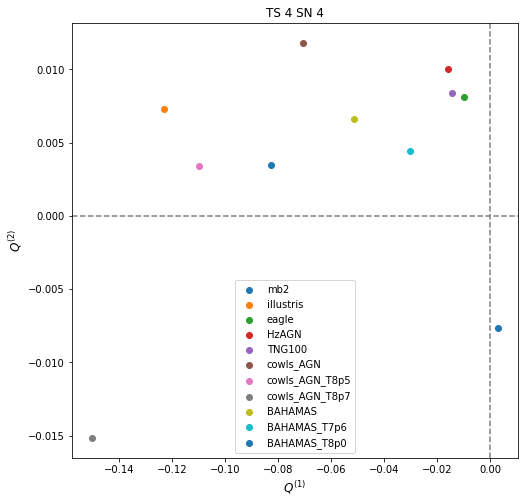

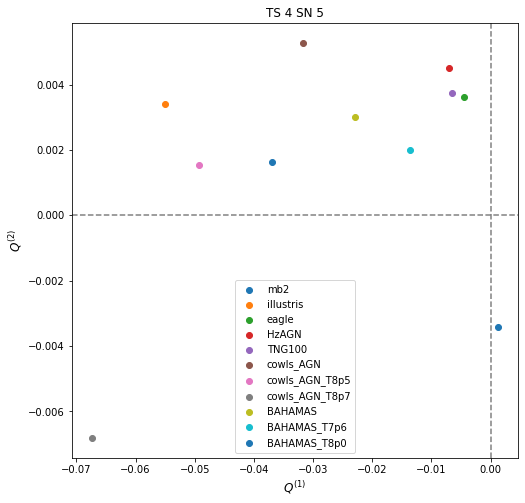

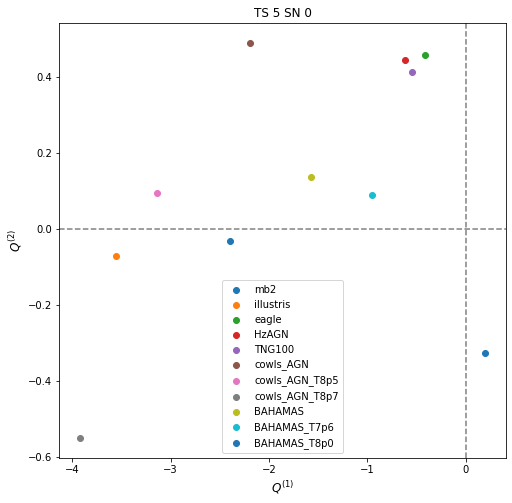

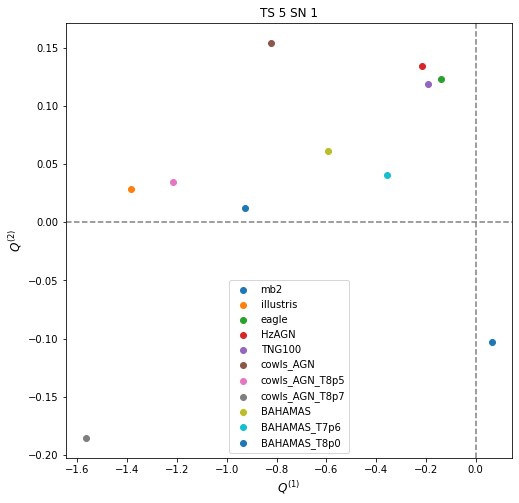

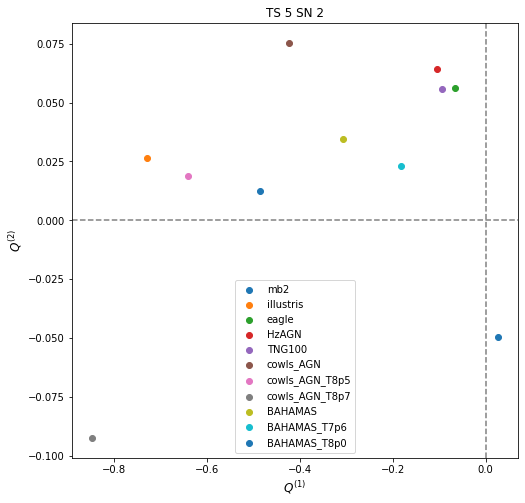

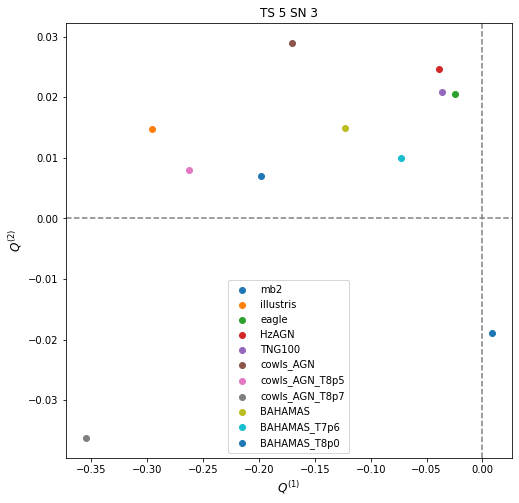

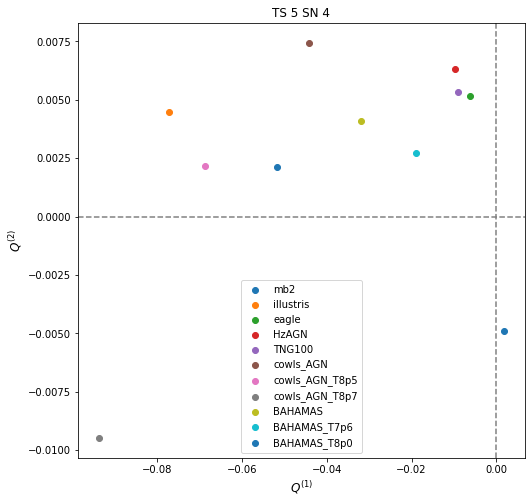

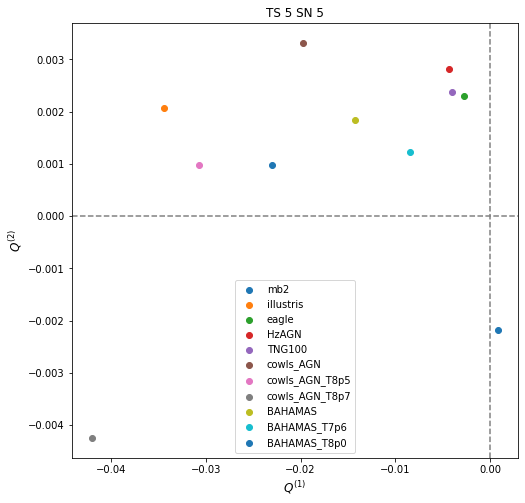

In [13]:
for i in range(6):
    for j in range(6):
        print(f'Target selection {i}; Shape noise {j}')
        fig, ax = plt.subplots(1,1, figsize=[8,8])
        Q1s, Q2s, Q3s = [], [], []
        for k,v in Qs_range_9sim[i*6+j].items():
            ax.scatter(v[0], v[1], label=k)
            Q1s.append(v[0])
            Q2s.append(v[1])
            Q3s.append(v[2])
        print(f'Q1 range ({np.min(Q1s)}, {np.max(Q1s)})')
        print(f'Q2 range ({np.min(Q2s)}, {np.max(Q2s)})')
        print(f'Q3 range ({np.min(Q3s)}, {np.max(Q3s)})')
        ax.set_title("TS %d SN %d"%(i,j))
        ax.set_xlabel(r'$Q^{(1)}$', fontsize=12)
        ax.set_ylabel(r'$Q^{(2)}$', fontsize=12)
        ax.axvline(0, ls='--', color='grey')
        ax.axhline(0, ls='--', color='grey')
        ax.legend()
        plt.savefig('test_imgs/PCA_Qrange/TS%d_SN%d_9sim.pdf'%(i,j))

Target selection 0; Shape noise 0
Q1 range (-44.283176133372464, 2.5367355290009463)
Q2 range (-8.59278293395422, 6.138351517844654)
Q3 range (-2.4164398771477726, 5.420649244647958)
Target selection 0; Shape noise 1
Q1 range (-24.909033233173513, 0.9608842056794459)
Q2 range (-3.5078591779938932, 2.5052483552983205)
Q3 range (-0.9633708461762992, 2.2544010449125653)
Target selection 0; Shape noise 2
Q1 range (-15.755862291939758, 0.46332776901209843)
Q2 range (-1.8560428124436366, 1.3226350278393486)
Q3 range (-1.2174401974380074, 0.49661596682804665)
Target selection 0; Shape noise 3
Q1 range (-7.425299953727307, 0.1536720563284954)
Q2 range (-0.7817957056295441, 0.5499327859666627)
Q3 range (-0.5091340801747024, 0.1994334996667623)
Target selection 0; Shape noise 4
Q1 range (-2.297830038062739, 0.025874696535596348)
Q2 range (-0.2272239741634135, 0.1552959796334193)
Q3 range (-0.054118089119819794, 0.13978200763889365)
Target selection 0; Shape noise 5
Q1 range (-1.0740706378713323,

/tmp/ipykernel_56403/1460751883.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=[8,8])


Target selection 3; Shape noise 3
Q1 range (-0.4897665659524776, 0.011230923931542519)
Q2 range (-0.050559051147172546, 0.0397451171490584)
Q3 range (-0.016952773880335816, 0.039780239958480706)
Target selection 3; Shape noise 4
Q1 range (-0.13094535942973384, 0.002491516507451659)
Q2 range (-0.013284517861179082, 0.010260791004900804)
Q3 range (-0.004381460062399935, 0.010559293328108373)
Target selection 3; Shape noise 5
Q1 range (-0.05870450244670487, 0.0010828421160825553)
Q2 range (-0.005960967310539495, 0.004581938250372237)
Q3 range (-0.001959199716175411, 0.004753419475226514)
Target selection 4; Shape noise 0
Q1 range (-5.291741722770622, 0.2983185072311761)
Q2 range (-0.8179326272842502, 0.7310165061762584)
Q3 range (-0.5696715641694327, 0.2938448874660404)
Target selection 4; Shape noise 1
Q1 range (-2.297148972826027, 0.10446836623698408)
Q2 range (-0.2834648525467129, 0.23099445271244018)
Q3 range (-0.21846634880909382, 0.10076611113117398)
Target selection 4; Shape noise 

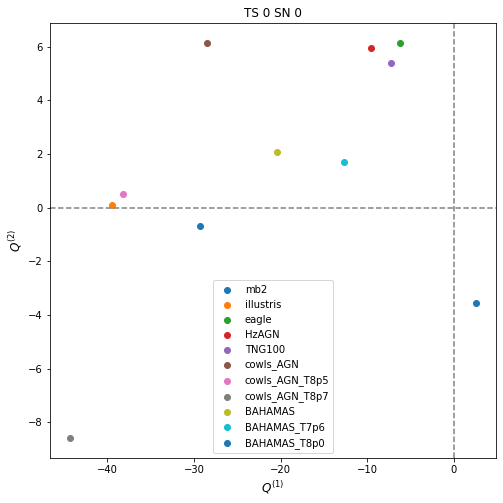

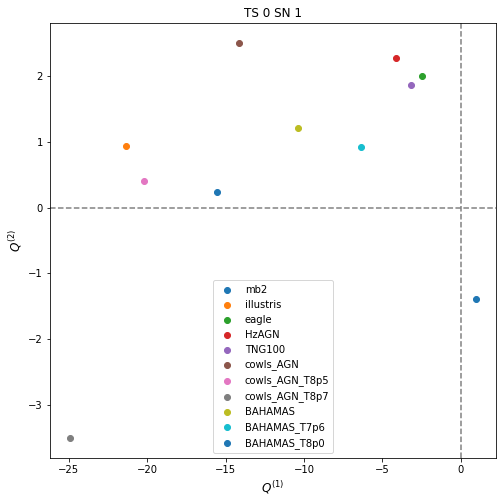

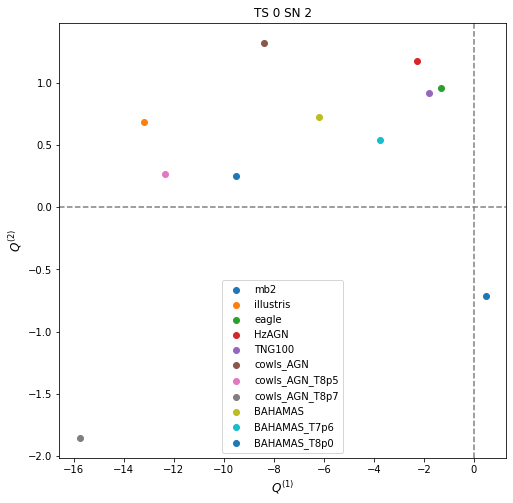

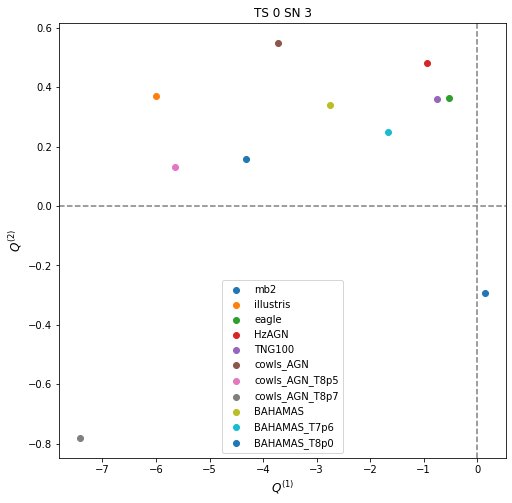

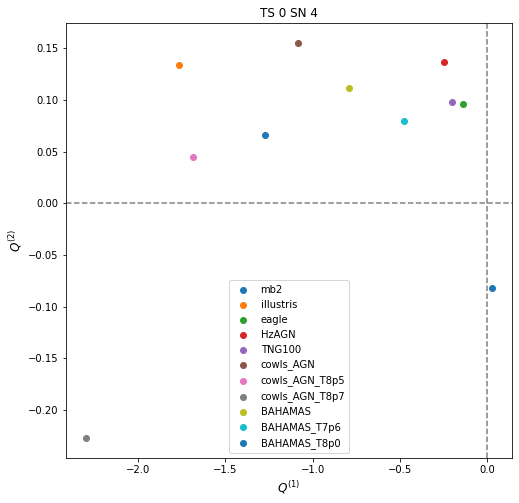

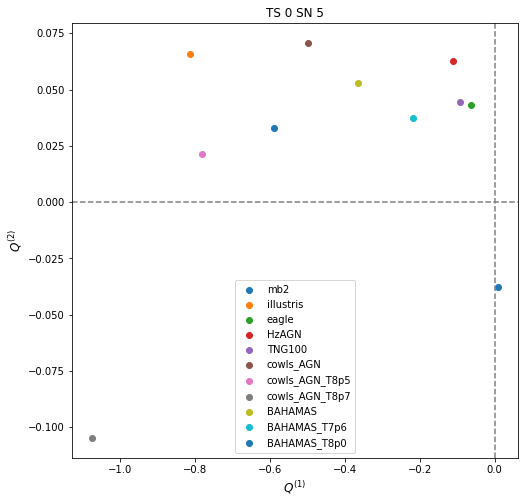

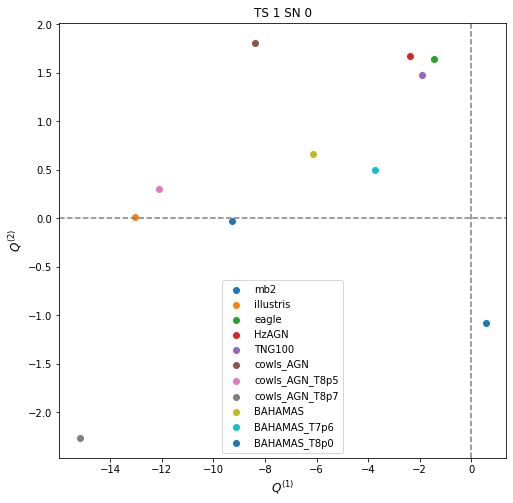

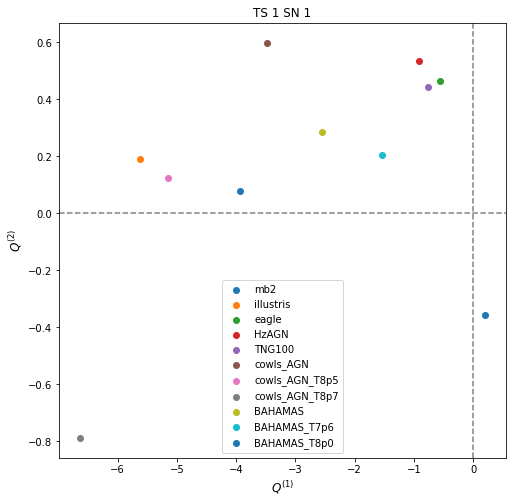

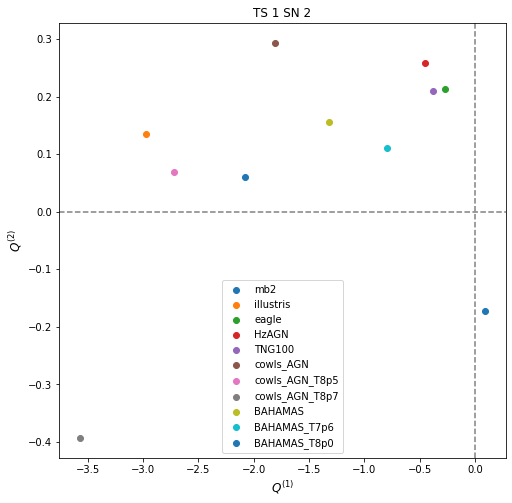

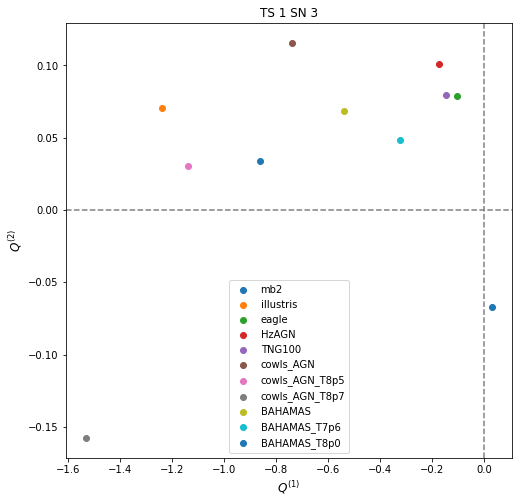

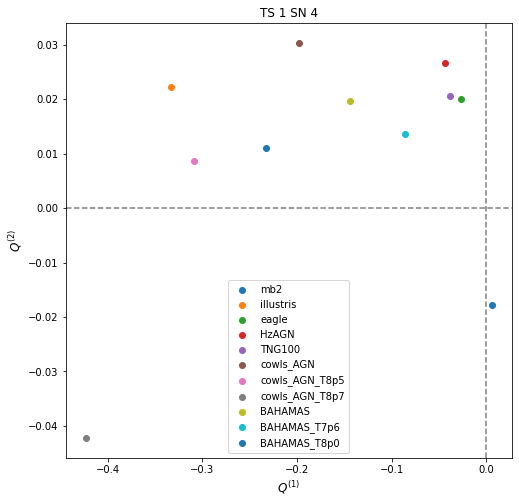

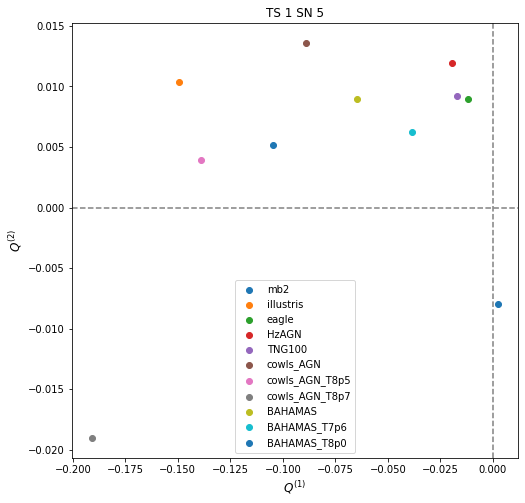

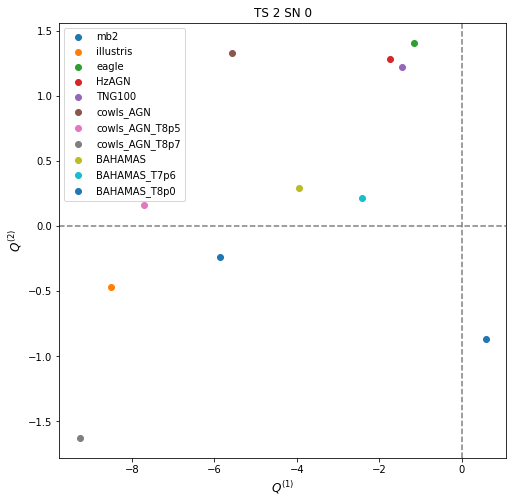

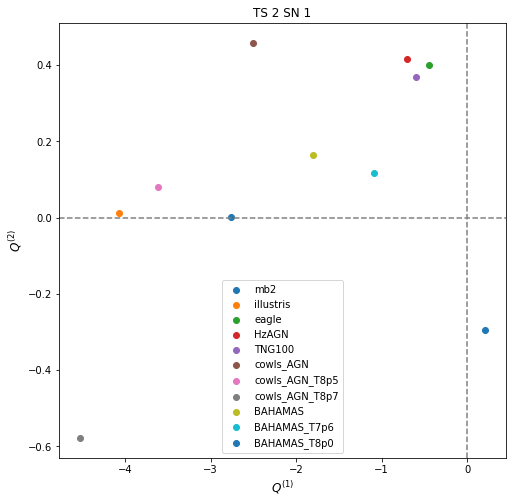

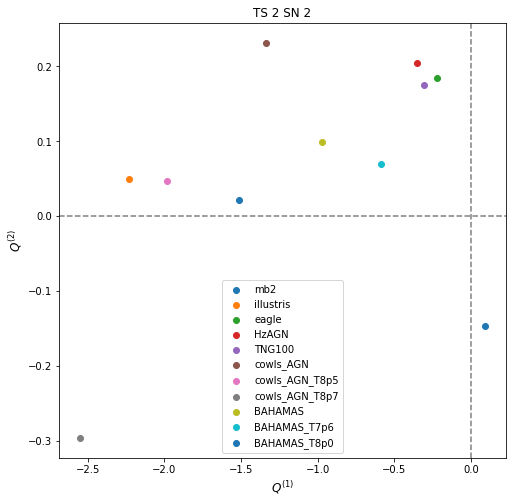

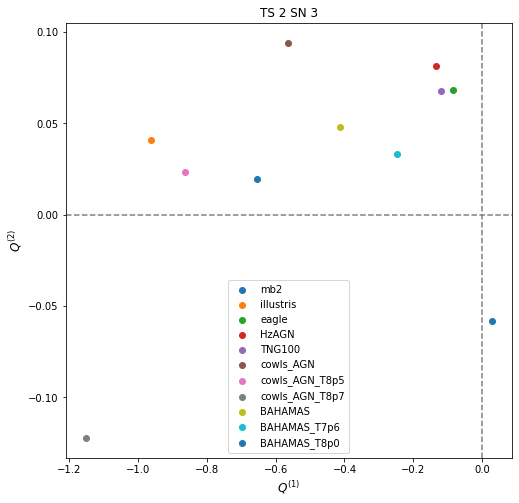

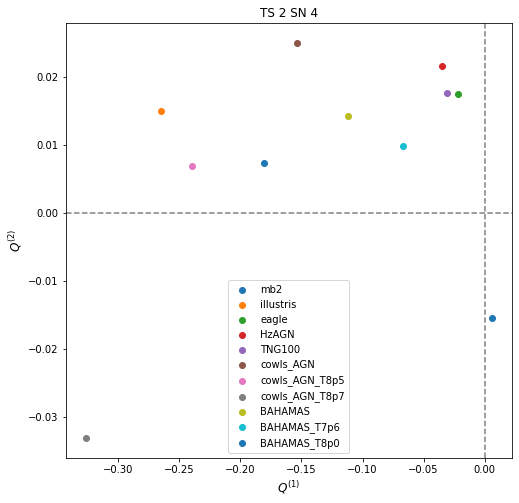

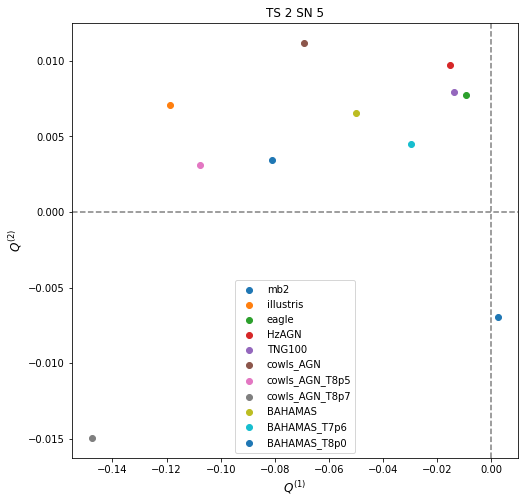

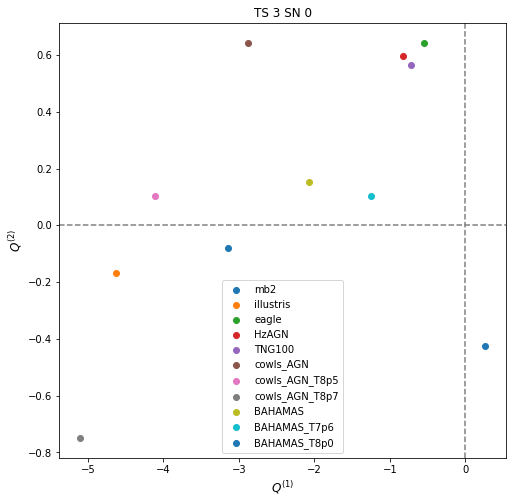

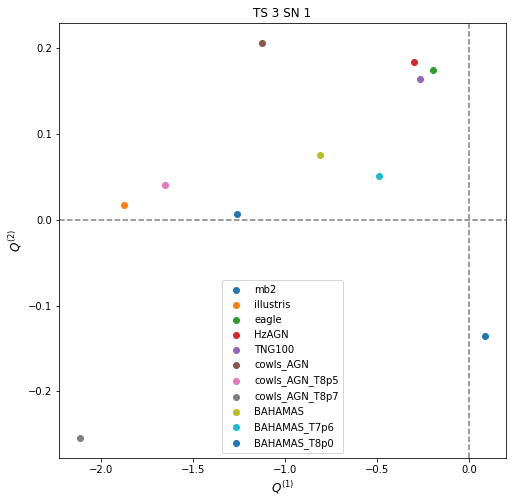

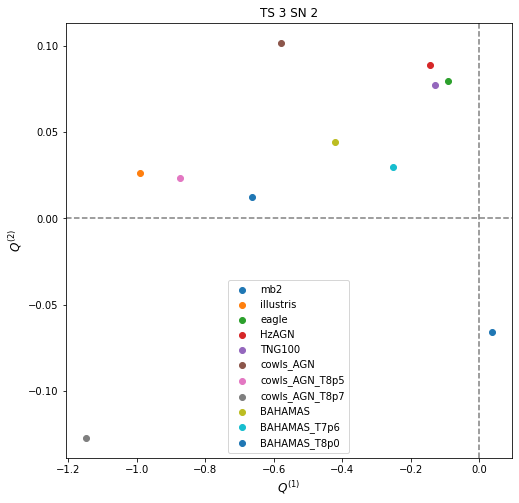

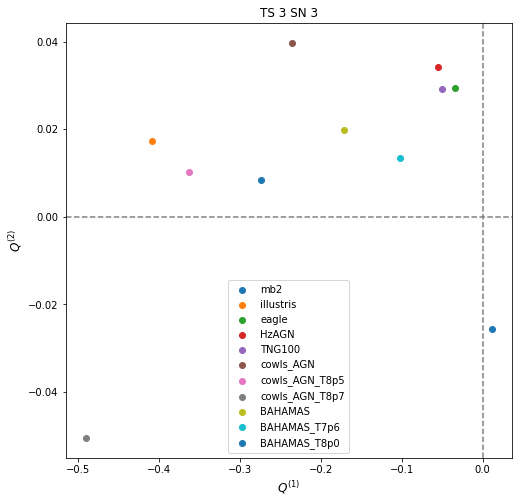

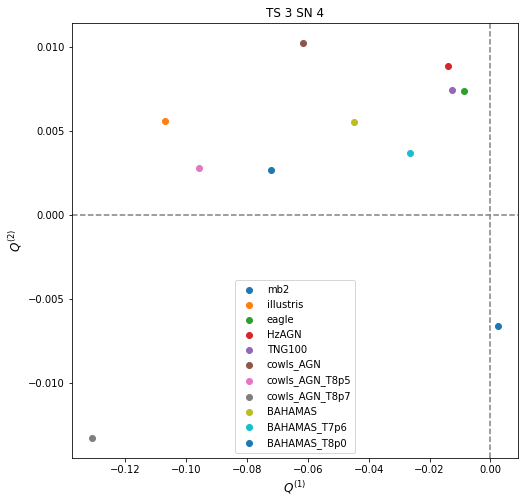

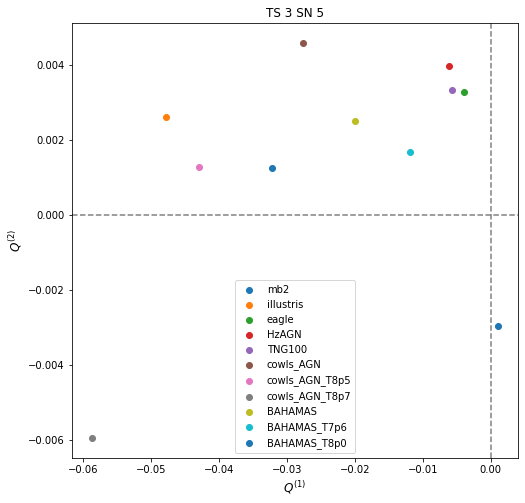

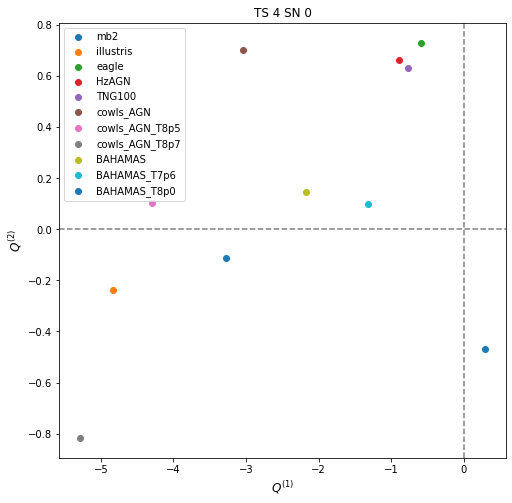

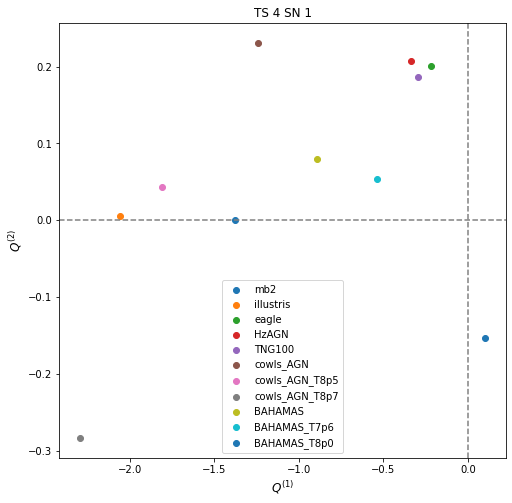

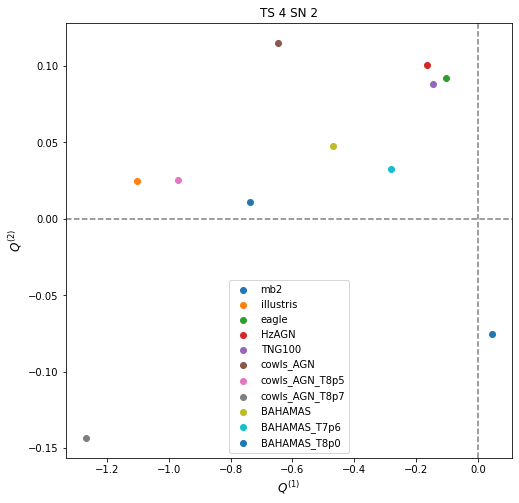

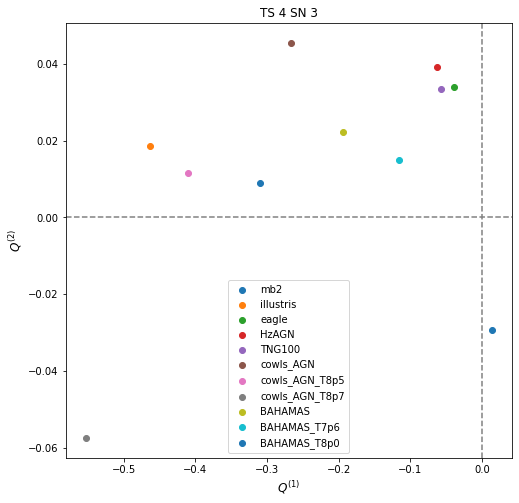

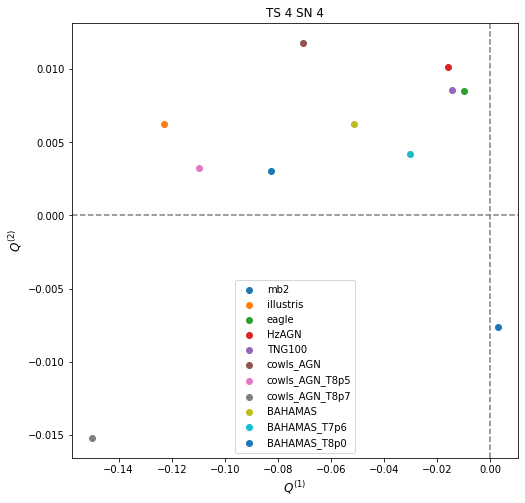

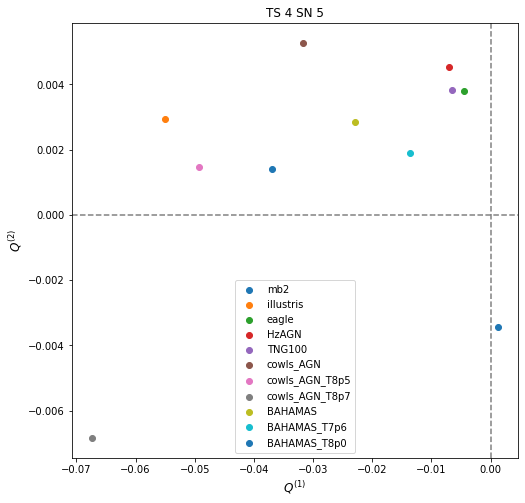

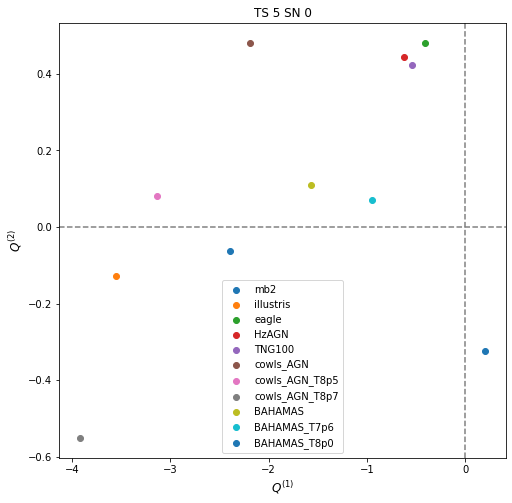

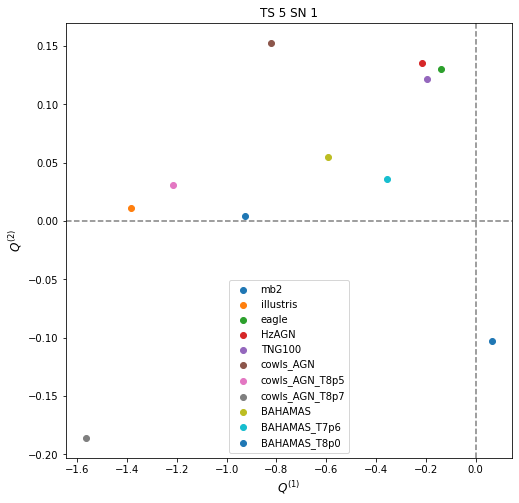

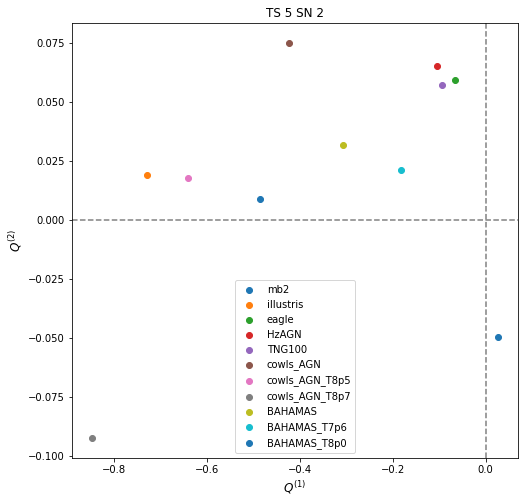

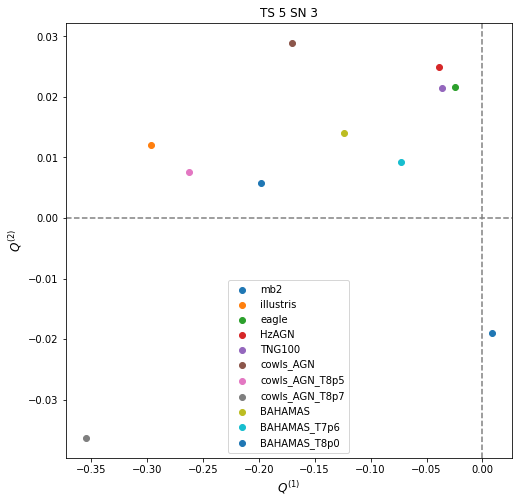

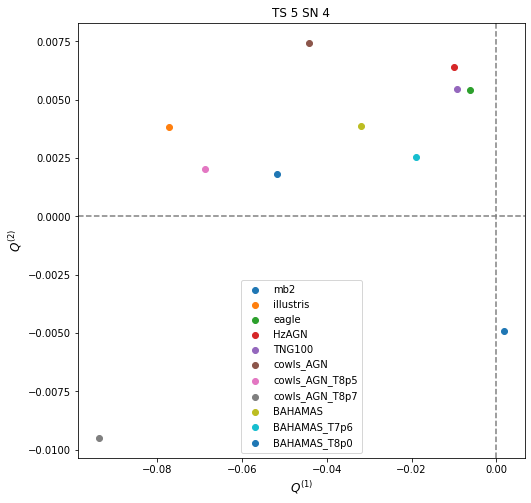

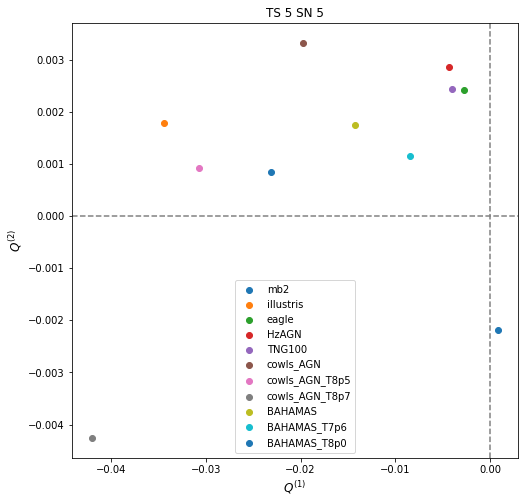

In [14]:
for i in range(6):
    for j in range(6):
        print(f'Target selection {i}; Shape noise {j}')
        fig, ax = plt.subplots(1,1, figsize=[8,8])
        Q1s, Q2s, Q3s = [], [], []
        for k,v in Qs_range_10sim[i*6+j].items():
            ax.scatter(v[0], v[1], label=k)
            Q1s.append(v[0])
            Q2s.append(v[1])
            Q3s.append(v[2])
        print(f'Q1 range ({np.min(Q1s)}, {np.max(Q1s)})')
        print(f'Q2 range ({np.min(Q2s)}, {np.max(Q2s)})')
        print(f'Q3 range ({np.min(Q3s)}, {np.max(Q3s)})')
        ax.set_title("TS %d SN %d"%(i,j))
        ax.set_xlabel(r'$Q^{(1)}$', fontsize=12)
        ax.set_ylabel(r'$Q^{(2)}$', fontsize=12)
        ax.axvline(0, ls='--', color='grey')
        ax.axhline(0, ls='--', color='grey')
        ax.legend()
        plt.savefig('test_imgs/PCA_Qrange/TS%d_SN%d_10sim.pdf'%(i,j))

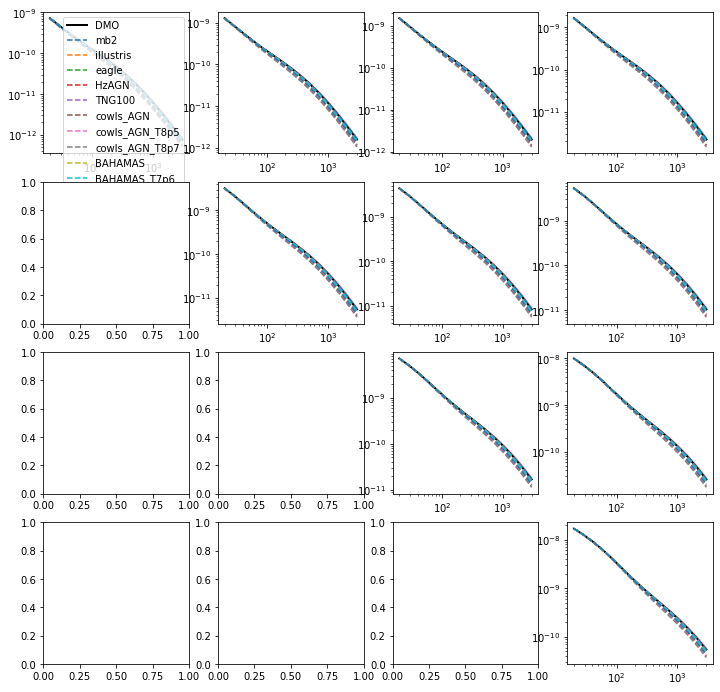

In [22]:
iSelect, iSN = 0, 0

# examine some PCs
fig, axes = plt.subplots(4, 4, figsize=(12,12))
Q1 = [0, 16]
ell = np.logspace(np.log10(20), np.log10(3000), 15)
### 
dv_dm = np.genfromtxt(dvfmt%(iSelect,0)+"_dmo")
PCs = np.genfromtxt(PCs_fmt%(iSelect, iSN))
dv_bary = []
for bary in bary_scenarios:
    _dv = np.genfromtxt(dvfmt%(iSelect,0)+"_%s"%bary)
    dv_bary.append(_dv)
ct = 0
for i in range(4):
    for j in range(i,4):
        ax = axes[i,j]
        ax.plot(ell, dv_dm[ct:ct+15,1], label='DMO', ls='-', color='k', lw=2)
        for dv,bary in zip(dv_bary,bary_scenarios):
            ax.plot(ell, dv[ct:ct+15,1], label=bary, ls='--')
        ax.fill_between(ell, 
                        dv_dm[ct:ct+15,1]+Q1[0]*PCs[ct:ct+15,0], 
                        dv_dm[ct:ct+15,1]+Q1[1]*PCs[ct:ct+15,0], 
                        label='PC1', color='pink',alpha=1)
        ax.set(xscale='log', yscale='log',)
        ct += 15
axes[0,0].legend()
plt.show()

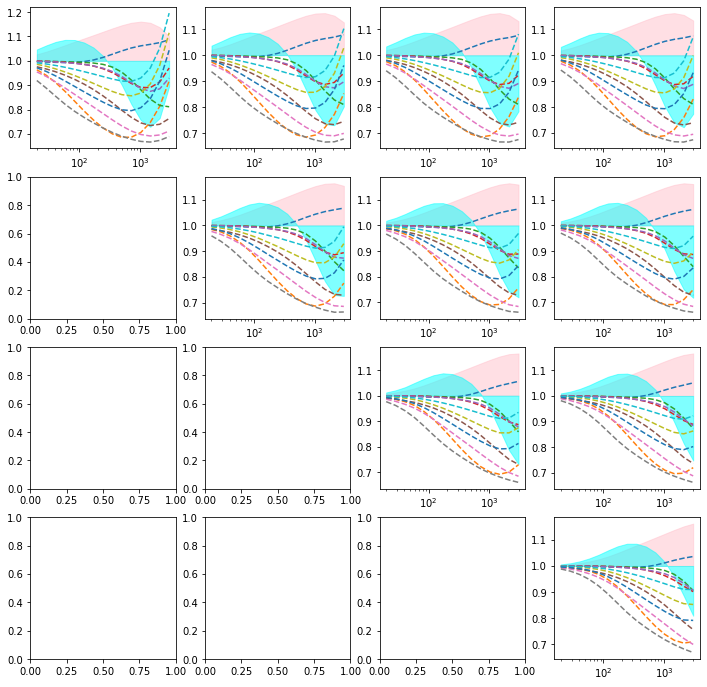

In [27]:
iSelect, iSN = 4,1
# examine some PCs
fig, axes = plt.subplots(4, 4, figsize=(12,12))
Q1 = [0, 1]
Q2 = [0, 1]
Q3 = [0, 1]
ell = np.logspace(np.log10(20), np.log10(3000), 15)
### 
dv_dm = np.genfromtxt(dvfmt%(iSelect,0)+"_dmo")
PCs = np.genfromtxt(PCs_fmt%(iSelect, iSN))
dv_bary = []
for bary in bary_scenarios:
    _dv = np.genfromtxt(dvfmt%(iSelect,0)+"_%s"%bary)
    dv_bary.append(_dv)
ct = 0
for i in range(4):
    for j in range(i,4):
        ax = axes[i,j]
        #ax.plot(ell, dv_dm[ct:ct+15,1], label='DMO', ls='-', color='k', lw=2)
        for dv,bary in zip(dv_bary,bary_scenarios):
            ax.plot(ell, dv[ct:ct+15,1]/dv_dm[ct:ct+15,1], label=bary, ls='--')
        ax.fill_between(ell, 
                        (dv_dm[ct:ct+15,1]+Q1[0]*PCs[ct:ct+15,0])/dv_dm[ct:ct+15,1], 
                        (dv_dm[ct:ct+15,1]+Q1[1]*PCs[ct:ct+15,0])/dv_dm[ct:ct+15,1], 
                        label='PC1', color='pink',alpha=0.5)
        ax.fill_between(ell, 
                        (dv_dm[ct:ct+15,1]+Q2[0]*PCs[ct:ct+15,1])/dv_dm[ct:ct+15,1], 
                        (dv_dm[ct:ct+15,1]+Q2[1]*PCs[ct:ct+15,1])/dv_dm[ct:ct+15,1], 
                        label='PC2', color='cyan',alpha=0.5)
#         ax.fill_between(ell, 
#                         (dv_dm[ct:ct+15,1]+Q3[0]*PCs[ct:ct+15,2])/dv_dm[ct:ct+15,1], 
#                         (dv_dm[ct:ct+15,1]+Q3[1]*PCs[ct:ct+15,2])/dv_dm[ct:ct+15,1], 
#                         label='PC3', color='green',alpha=0.5)
        ax.set(xscale='log',)
        ct += 15
plt.show()